## 1. Importing Libraries

In [ ]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

## 2. Gathering Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

global_dir = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/"
os.listdir(global_dir)

# Set directories
test_path= "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/test"
train_path = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/train"
valid_path = "gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/valid"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#### Showing some pictures from the database we just imported

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


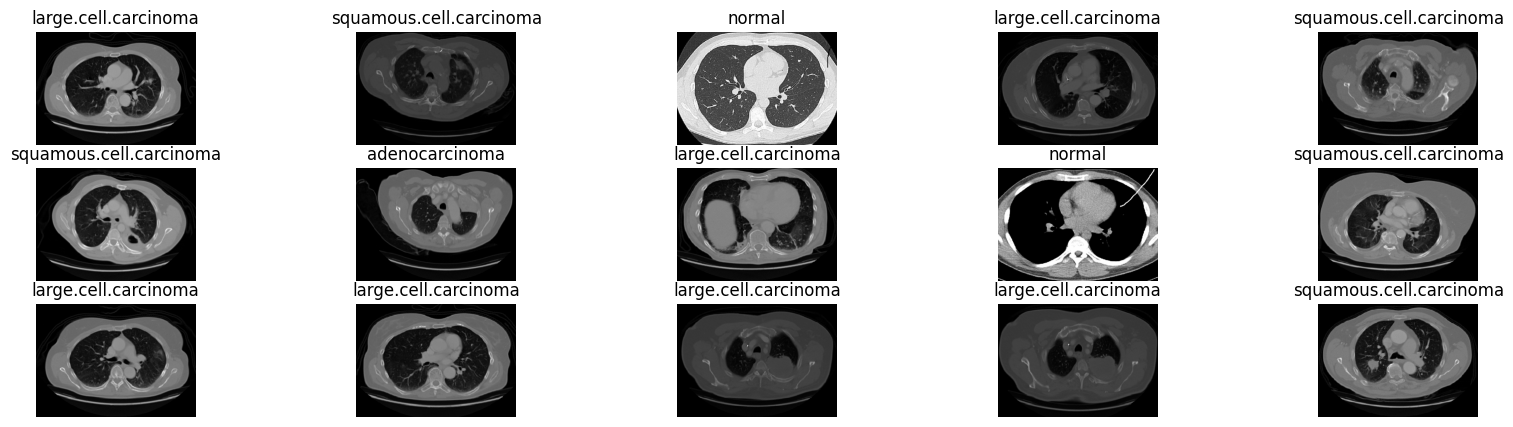

In [ ]:
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])


## 3. Building the model

In [ ]:
first_model = Sequential([
  Conv2D(8, 2, padding='same', activation='relu', input_shape = image_shape),
  MaxPooling2D(2),
  Conv2D(16, 2, padding='same', activation='relu'),
  MaxPooling2D(2),

  Dropout(0.4),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(4, activation='softmax')
])
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 76, 107, 16)       0         
                                                                 
 flatten (Flatten)           (None, 130112)            0

## 4. Training the model

In [ ]:
checkpointer = ModelCheckpoint('gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = first_model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 5,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.3268 - acc: 0.3703
Epoch 1: val_loss improved from inf to 1.27808, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5
20/20 [==============================] - 170s 8s/step - loss: 1.3268 - acc: 0.3703 - val_loss: 1.2781 - val_acc: 0.4583
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 1.1878 - acc: 0.4372
Epoch 2: val_loss improved from 1.27808 to 1.24856, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5
20/20 [==============================] - 53s 3s/step - loss: 1.1878 - acc: 0.4372 - val_loss: 1.2486 - val_acc: 0.4028
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 1.0802 - acc: 0.5139
Epoch 3: val_loss improved from 1.24856 to 1.17226, saving model to gdrive/My Drive/Colab Notebooks/Lung_cancer_codes/deep learning methods/Data/transfer_model.hdf5
20/20 

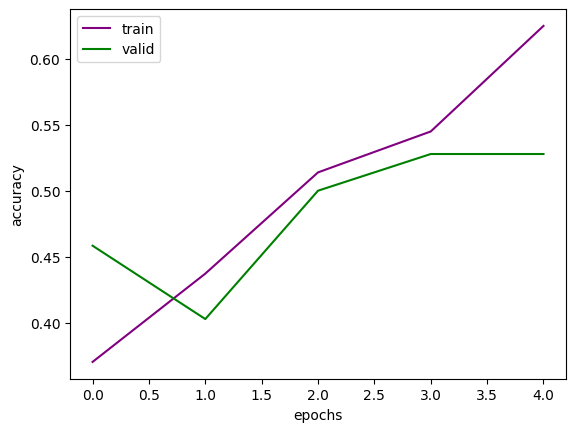

In [ ]:
plt.plot(history.history['acc'], 'purple',label = 'train',)
plt.plot(history.history['val_acc'],'green', label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = first_model.evaluate(test_generator)

10/10 [==============================] - 3s 290ms/step - loss: 1.4337 - acc: 0.5460


## 5. Transfer learning

#### DenseNet201

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.

Found 72 images belonging to 4 classes.

Found 315 images belonging to 4 classes.


In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False


74836368/74836368 [==============================] - 8s 0us/step


In [ ]:
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_6"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 densenet201 (Functional)    (None, 1920)              18321984  

                                                                 

 flatten_6 (Flatten)         (None, 1920)              0         

                                                                 

 batch_normalization_5 (Batc  (None, 1920)             7680      

 hNormalization)                                                 

                                                                 

 dense_7 (Dense)             (None, 4)                 7684      

                                                                 


Total params: 18,337,348

Trainable params: 6,990,084

Non-trainable params: 11,347,264

_________________________________________________________________


In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 80,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/80

20/20 [==============================] - ETA: 0s - loss: 1.2077 - acc: 0.4715 

Epoch 1: val_loss improved from inf to 1.32328, saving model to .\chestmodel-DenseNet201.hdf5

20/20 [==============================] - 406s 20s/step - loss: 1.2077 - acc: 0.4715 - val_loss: 1.3233 - val_acc: 0.4444

Epoch 2/80

20/20 [==============================] - ETA: 0s - loss: 0.7304 - acc: 0.7423 

Epoch 2: val_loss improved from 1.32328 to 1.21350, saving model to .\chestmodel-DenseNet201.hdf5

20/20 [==============================] - 384s 19s/step - loss: 0.7304 - acc: 0.7423 - val_loss: 1.2135 - val_acc: 0.5139

Epoch 3/80

20/20 [==============================] - ETA: 0s - loss: 0.5154 - acc: 0.8287 

Epoch 3: val_loss improved from 1.21350 to 1.12467, saving model to .\chestmodel-DenseNet201.hdf5

20/20 [==============================] - 391s 20s/step - loss: 0.5154 - acc: 0.8287 - val_loss: 1.1247 - val_acc: 0.5694

Epoch 4/80

20/20 [==============================] - ETA: 0s - lo

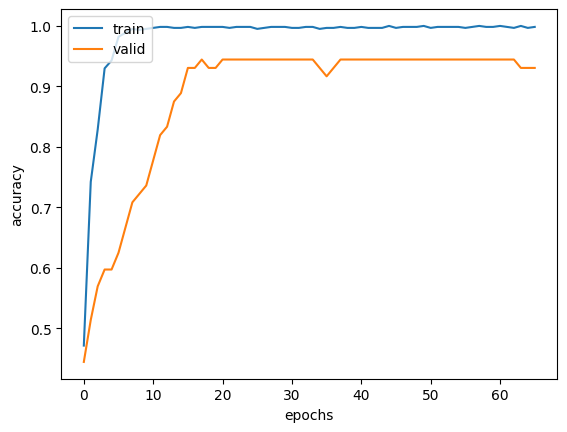

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
dns_result = densenet_model.evaluate(test_generator)

10/10 [==============================] - 128s 13s/step - loss: 0.4475 - acc: 0.8286


#### ResNet50

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.

Found 72 images belonging to 4 classes.

Found 315 images belonging to 4 classes.


In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(N_CLASSES, activation='softmax'))
resnet_model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2048)              23587712  

                                                                 

 dropout (Dropout)           (None, 2048)              0         

                                                                 

 flatten (Flatten)           (None, 2048)              0         

                                                                 

 batch_normalization (BatchN  (None, 2048)             8192      

 ormalization)                                                   

                                                                 

 dropout_1 (Dropout)         (None, 2048)              0         

                                                                 

 dense (Dense)               (None, 4)                 8196      

                                        

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch = 20,
                            epochs = 120,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

Epoch 1/120

20/20 [==============================] - ETA: 0s - loss: 1.9844 - acc: 0.3116 

Epoch 1: val_loss improved from inf to 1.14999, saving model to .\finalmodel-ResNet50.hdf5

20/20 [==============================] - 238s 12s/step - loss: 1.9844 - acc: 0.3116 - val_loss: 1.1500 - val_acc: 0.5000

Epoch 2/120

20/20 [==============================] - ETA: 0s - loss: 1.3769 - acc: 0.4698 

Epoch 2: val_loss improved from 1.14999 to 1.03860, saving model to .\finalmodel-ResNet50.hdf5

20/20 [==============================] - 258s 13s/step - loss: 1.3769 - acc: 0.4698 - val_loss: 1.0386 - val_acc: 0.5278

Epoch 3/120

20/20 [==============================] - ETA: 0s - loss: 1.1116 - acc: 0.5498 

Epoch 3: val_loss improved from 1.03860 to 0.98371, saving model to .\finalmodel-ResNet50.hdf5

20/20 [==============================] - 250s 13s/step - loss: 1.1116 - acc: 0.5498 - val_loss: 0.9837 - val_acc: 0.5417

Epoch 4/120

20/20 [==============================] - ETA: 0s - loss: 0

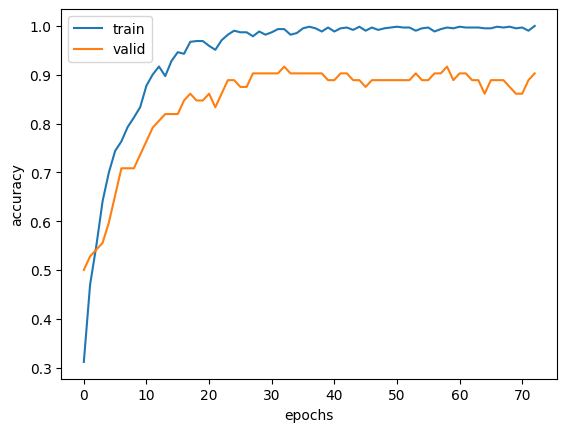

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = resnet_model.evaluate(test_generator)

10/10 [==============================] - 94s 9s/step - loss: 0.3730 - acc: 0.8730


## 6. Making predictions with best model (ResNet50)

In [ ]:
from keras.models import load_model
resnet50_model = load_model('finalmodel-ResNet50.hdf5')

#### Confusion Matrix

In [ ]:
paths = ["data/test/adenocarcinoma/", "data/test/large.cell.carcinoma/", "data/test/normal/", "data/test/squamous.cell.carcinoma/"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(460, 460)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = resnet50_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

{'adeno': {0: 99, 1: 5, 2: 0, 3: 16},
 'large': {0: 6, 1: 43, 2: 0, 3: 2},
 'normal': {0: 0, 1: 1, 2: 53, 3: 0},
 'squamous': {0: 7, 1: 3, 2: 0, 3: 80}}

In [ ]:
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) / 315 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

Overall accuracy is : 87.30%



Adeno cancer detection accuracy is : 82.50%

Large cell cancer detection accuracy is : 84.31%

Normal chest detection accuracy is : 98.15%

Squamous cell cancer detection accuracy is : 88.89%



Confusion Matrix :


,0,1,2,3
adeno,99,5,0,16
large,6,43,0,2
normal,0,1,53,0
squamous,7,3,0,80


#### Predict for one picture

In [ ]:
img_path = "data/test/squamous.cell.carcinoma/000111.png"

class_names=list(test_generator.class_indices.keys())

img = tf.keras.utils.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = resnet50_model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)


1/1 [==============================] - 0s 397ms/step

This image most likely belongs to squamous.cell.carcinoma with a 98.31 percent confidence.
